Solving the parametric unsteady advection problem: Transport of a Gaussian

\begin{equation}
\frac{\partial u}{\partial t} + \nabla \cdot \left(\vec{b} u\right) = f  \tag*{in $\Omega \times I$}
\end{equation}
\begin{equation}
u = u_{ex} \tag*{on $\Gamma_D = \delta\Omega$}
\end{equation}

where:

\begin{equation}
\Omega = (0,1) \times (0,1)
\end{equation}

\begin{equation}
I = (0,1)
\end{equation}

\begin{equation}
u_{ex}(x,y,t) = 0.5 \cdot \exp\left(-\frac{\|\vec x - \vec x_c\|^2}{2\sigma^2}\right)
\end{equation}

with:

\begin{equation}
x_c = \frac{\sin(2\pi t)}{4.0} + 0.5
\end{equation}

\begin{equation}
y_c = \frac{\cos(2\pi t)}{4.0} + 0.5
\end{equation}

and the parameter $\sigma \in \left(0.5,5\right)$

In [2]:
!pip install deepxde==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 939.1 kB/s eta 0:00:00a 0:00:01


In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import random
from scipy.stats import qmc

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


2022-11-13 10:40:17.935814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 10:40:18.032753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 10:40:18.033536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.



Set the default float type to float64


(-0.05, 1.05, -0.05, 1.05)

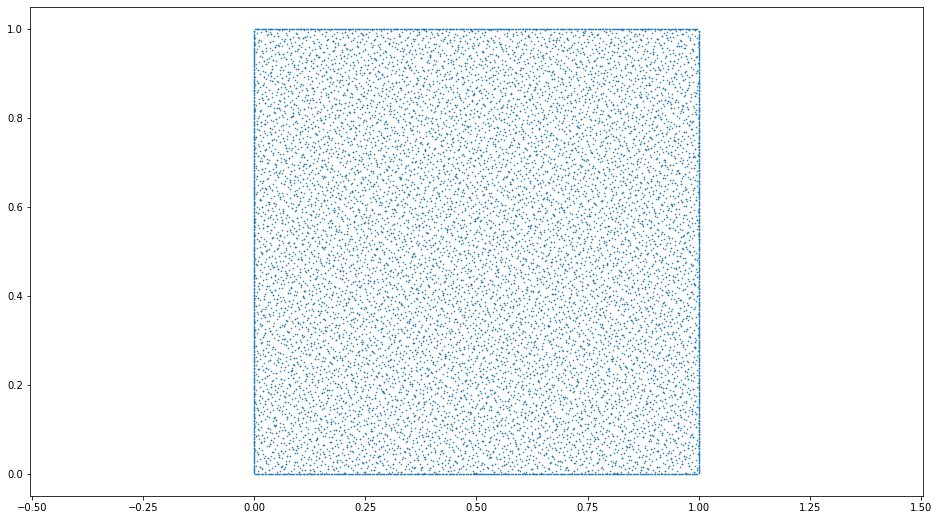

In [4]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

x_min = [0.0, 0.0, 0.1]
x_max = [1.0, 1.0, 1.0]

def parametric_a(x, y):
    """
    PDE residual to be minimized - Paramteric Advection equation
    
    """
    
    bx = 2*np.pi*(x[:, 1:2] - 0.5)
    by = 2*np.pi*(0.5 - x[:, 0:1])
 
    u_t = dde.grad.jacobian(y, x, i = 0, j = 3)
    u_x = dde.grad.jacobian(y, x, i = 0, j = 0)
    u_y = dde.grad.jacobian(y, x, i = 0, j = 1)
    
    
    eq = u_t + dde.grad.jacobian(bx * y, x, i = 0, j = 0) + dde.grad.jacobian(by * y, x, i = 0, j = 1)
    
    return eq

# Geometry defintion
geom = dde.geometry.Cuboid(x_min, x_max)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def sol_ex(x):
    xc = np.sin(2*np.pi * x[:, 3:4]) / 4.0 + 0.5
    yc = np.cos(2*np.pi * x[:, 3:4]) / 4.0 + 0.5
    return 0.5 * np.exp(-1000 * x[:, 2:3] * ((x[:, 0:1] - xc)**2 + (x[:, 1:2] - yc)**2))

def initial_sol(x):
    return 0.5 * np.exp(-1000 * x[:, 2:3] * ((x[:, 0:1] - 0.5)**2 + (x[:, 1:2] - 0.75)**2))

# Boundaries definition
def boundary(x, on_boundary):
    return on_boundary
                        
def initial(x, on_initial):
    return on_initial
  
# Boundary conditions assembly   
bc = dde.DirichletBC(geomtime, sol_ex, boundary)
ic = dde.IC(geomtime, initial_sol, initial)

# Problem setup
data = dde.data.TimePDE(geomtime, parametric_a, ic_bcs = [bc, ic], num_domain = 10000, num_boundary = 2500, num_initial = 2500, num_test = 1000, solution = sol_ex)

plt.figure(figsize = (16, 9))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

Compiling model...
Building feed-forward neural network...
'build' took 0.116717 s



/opt/conda/lib/python3.7/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2022-11-13 10:40:21.031386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 10:40:21.032089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative 

'compile' took 4.054005 s

Initializing variables...


2022-11-13 10:40:25.161466: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f0048008c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-13 10:40:25.161538: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2022-11-13 10:40:25.532935: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-11-13 10:40:25.678199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.79e-05, 4.71e-03, 9.67e-03]    [1.02e-05, 4.71e-03, 9.67e-03]    [1.01e+00]    
100       [3.45e-05, 4.53e-03, 9.18e-03]    [1.31e-05, 4.53e-03, 9.18e-03]    [9.85e-01]    
200       [3.45e-05, 4.46e-03, 9.11e-03]    [1.38e-05, 4.46e-03, 9.11e-03]    [9.79e-01]    
300       [3.78e-05, 4.37e-03, 9.03e-03]    [1.52e-05, 4.37e-03, 9.03e-03]    [9.78e-01]    
400       [3.88e-05, 4.35e-03, 9.02e-03]    [1.55e-05, 4.35e-03, 9.02e-03]    [9.77e-01]    
500       [3.64e-05, 4.35e-03, 9.00e-03]    [1.35e-05, 4.35e-03, 9.00e-03]    [9.75e-01]    
600       [3.65e-05, 4.33e-03, 8.98e-03]    [1.37e-05, 4.33e-03, 8.98e-03]    [9.75e-01]    
700       [4.17e-05, 4.33e-03, 8.95e-03]    [1.67e-05, 4.33e-03, 8.95e-03]    [9.72e-01]    
800       [4.75e-05, 4.31e-03, 8.92e-03]    [2.28e-05, 4.31e-03, 8.92e-03]    [9.71e-01]    
900       [5.78e-05, 4.31e-03, 8.91e-03]    [2.49e-

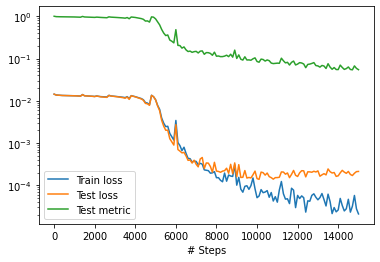

In [5]:
# Neural network definition
layer_size  = [4] + [60] * 6 + [1]
activation  = 'swish' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)
model.compile(optimizer = 'adam', lr = 1e-3, metrics=["l2 relative error"], loss_weights = [1, 5, 10])
    
losshistory, train_state = model.train(epochs = 15000, display_every = 100, model_save_path = './')
dde.saveplot(losshistory, train_state, issave = True, isplot = True)

In [6]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-8,
    maxiter=35000,
    maxfun=35000,
    maxls=50,
    )

model.compile(optimizer = 'L-BFGS-B', loss_weights = [1,5,10])
    
losshistory, train_state = model.train(display_every = 100, model_save_path = './')

Compiling model...
'compile' took 1.473949 s



2022-11-13 10:47:21.714585: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1652] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss                        Test loss                         Test metric
15000     [1.15e-05, 3.62e-06, 5.86e-06]    [2.03e-04, 3.62e-06, 5.86e-06]    []  
15100     [5.79e-06, 1.11e-06, 1.38e-06]                                          
15200     [5.39e-06, 9.90e-07, 1.21e-06]                                          
15300     [4.88e-06, 8.75e-07, 1.05e-06]                                          
15400     [4.28e-06, 7.77e-07, 9.06e-07]                                          
15500     [3.84e-06, 7.02e-07, 7.32e-07]                                          
15600     [3.47e-06, 6.14e-07, 6.30e-07]                                          
15700     [3.06e-06, 5.40e-07, 5.45e-07]                                          
15800     [2.72e-06, 4.82e-07, 4.77e-07]                                          
15900     [2.38e-06, 4.45e-07, 4.32e-07]                                          
16000     [2.11e-06, 3.92e-07, 4.12e-07]                     

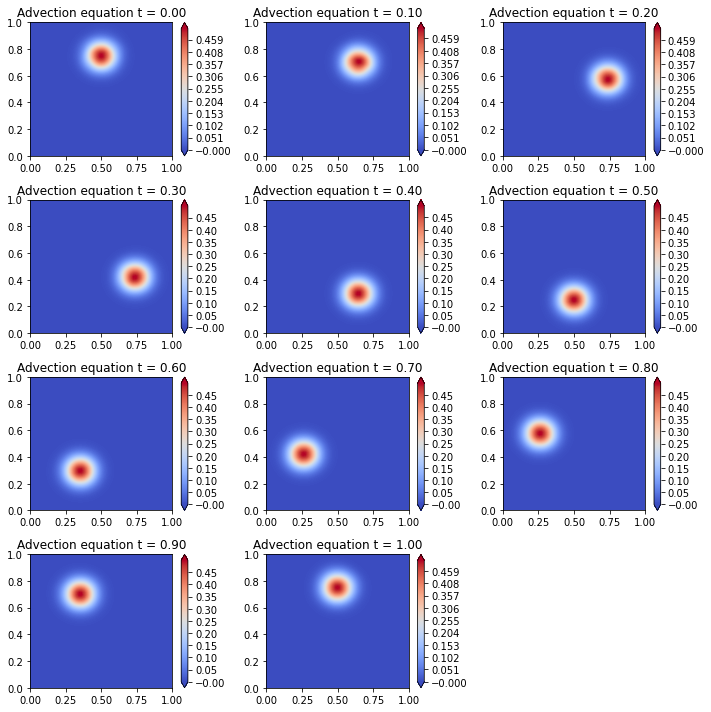

<Figure size 432x288 with 0 Axes>

In [7]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(0, 1 + dy, dx)
y = np.arange(0, 1 + dy, dy)

X = np.zeros((len(x)*len(y), 4))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

fig1, ax1 = plt.subplots(4, 3, figsize = (10, 10))
ax1 = ax1.flatten()
ax1[-1].set_axis_off()
count = 0

for ax in ax1.reshape(-1)[:-1]: 
    
    
    X[:, 2] = 0.1
    X[:, 3] = count

    # Model predictions generationt
    u = model.predict(X)
    u = np.squeeze(u, axis = 1)

    u = u.reshape(len(y), len(x))


    mmin = np.min([u.min()])
    mmax = np.max([u.max()]) 

    
    clev = np.arange(mmin, mmax, 0.001)
    cnt1 = ax.contourf(x, y, u, clev, cmap = plt.cm.coolwarm, extend='both')
    plt.axis('equal')
    ax.title.set_text(("Advection equation t = {:.2f}".format(count)))
    fig1.colorbar(cnt1, ax = ax)
    
    count = count + 0.1

plt.tight_layout()
plt.show()
plt.savefig('Advection-Diffusion.png')

In [9]:
def sol_ex(x):
    xc = np.sin(2*np.pi * x[:, 3:4]) / 4.0 + 0.5
    yc = np.cos(2*np.pi * x[:, 3:4]) / 4.0 + 0.5
    return 0.5 * np.exp(-1000 * x[:, 2:3] * ((x[:, 0:1] - xc)**2 + (x[:, 1:2] - yc)**2))

u_ex = sol_ex(X)
u_ex = np.reshape(u_ex, (101,101))
err = np.linalg.norm(u - u_ex) / np.linalg.norm(u_ex)
print(err)

0.01034840638685686
